In [1]:
import numpy as np
import pandas as pd
import os

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_squared_error
from math import sqrt

from statsmodels.tsa.seasonal import seasonal_decompose                       
from statsmodels.tools.eval_measures import rmse
import warnings

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam


import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.io as pio
pio.renderers.default = "svg"

In [2]:
df = pd.read_csv('silver-prices.csv')
df['Silver Price'] = 1 / df['Silver Price']

In [3]:
df.head()

,Date,Silver Price
0,2013-01-01,30.279999
1,2013-01-02,30.970002
2,2013-01-03,30.130002
3,2013-01-04,30.210002
4,2013-01-05,NaN


In [4]:
df = df.dropna()

In [5]:
df.isna().sum()

Date            0
Silver Price    0
dtype: int64

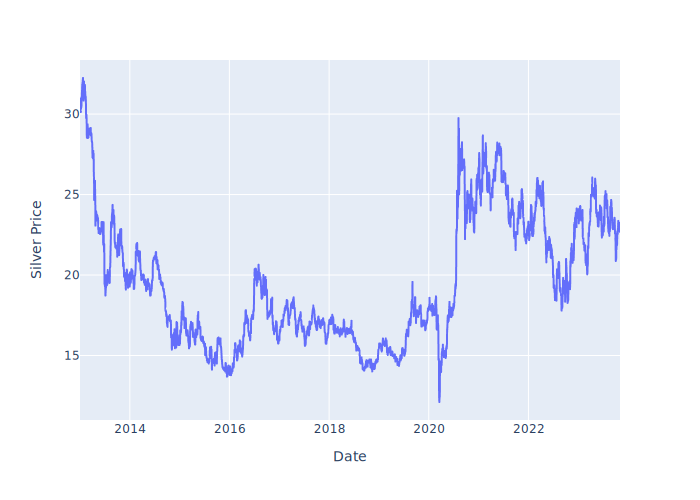

In [6]:
fig = px.line(df, x="Date", y="Silver Price")
fig.show()

In [7]:
df['Date'] = pd.to_datetime(df['Date'])

In [8]:

df.set_index('Date', inplace=True)

decomposition = seasonal_decompose(df["Silver Price"], model = "add", period = 365)

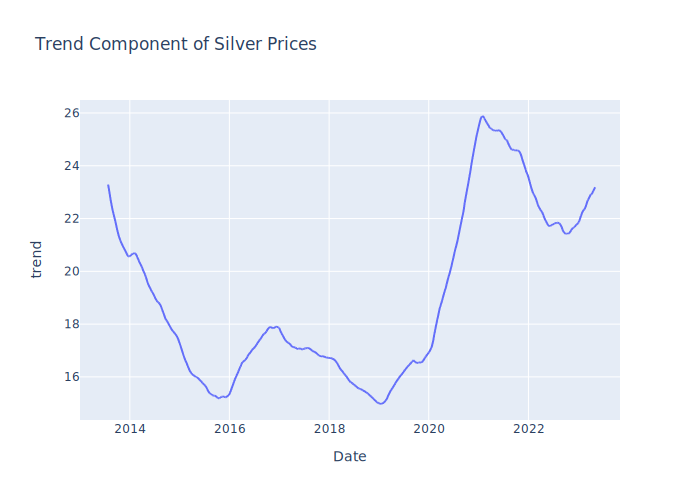

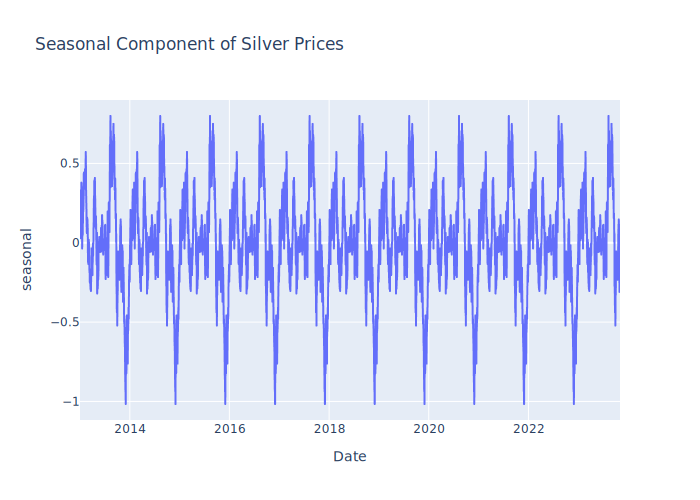

In [9]:
trend = decomposition.trend.reset_index()
seasonal = decomposition.seasonal.reset_index()

fig_trend = px.line(trend, x='Date', y='trend', title='Trend Component of Silver Prices')
fig_seasonal = px.line(seasonal, x='Date', y='seasonal', title='Seasonal Component of Silver Prices')

fig_trend.show()
fig_seasonal.show()

In [10]:
print(len(df))
train = df.iloc[:3600]
test = df.iloc[3600:]

3934


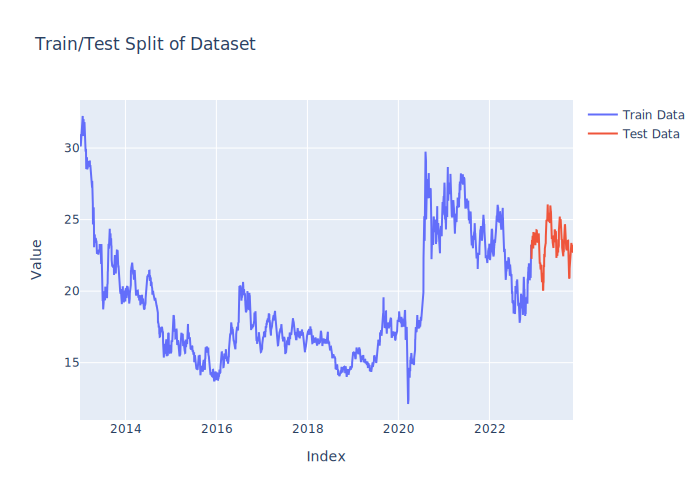

In [11]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=train.index, y=train['Silver Price'], mode='lines', name='Train Data'))
fig.add_trace(go.Scatter(x=test.index, y=test['Silver Price'], mode='lines', name='Test Data'))

fig.update_layout(title='Train/Test Split of Dataset', xaxis_title='Index', yaxis_title='Value')

fig.show()

In [12]:
train_data = train['Silver Price'].values.reshape(-1, 1)
test_data = test['Silver Price'].values.reshape(-1, 1)


scaler = MinMaxScaler()
scaler.fit(train_data)
scaled_train_data = scaler.transform(train_data)
scaled_test_data = scaler.transform(test_data)

In [13]:
def create_dataset(data, look_back):
    X, Y = [], []
    for i in range(len(data)-look_back-1):
        a = data[i:(i+look_back), 0]
        X.append(a)
        Y.append(data[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 10
X_train, y_train = create_dataset(scaled_train_data, look_back)
X_test, y_test = create_dataset(scaled_test_data ,look_back)

X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [14]:
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

epochs = 30
batch_size = 32
learning_rate = 0.001
# Model building
model = Sequential()
model.add(LSTM(50, input_shape=(1, look_back)))
#model.add(Dropout(0.2))
model.add(Dense(1))
optimizer = Adam(learning_rate=learning_rate)

model.compile(optimizer=optimizer, loss='mean_squared_error')
early_stop = EarlyStopping(monitor='val_loss', patience=10)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                12200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 12,251
Trainable params: 12,251
Non-trainable params: 0
_________________________________________________________________


In [15]:
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), callbacks=[early_stop], verbose=1)

Epoch 1/30
113/113 [==============================] - 3s 9ms/step - loss: 0.0215 - val_loss: 0.0013
Epoch 2/30
113/113 [==============================] - 0s 3ms/step - loss: 0.0011 - val_loss: 0.0012
Epoch 3/30
113/113 [==============================] - 0s 3ms/step - loss: 9.5073e-04 - val_loss: 0.0011
Epoch 4/30
113/113 [==============================] - 0s 3ms/step - loss: 9.0272e-04 - val_loss: 0.0010
Epoch 5/30
113/113 [==============================] - 0s 3ms/step - loss: 8.4524e-04 - val_loss: 0.0010
Epoch 6/30
113/113 [==============================] - 0s 3ms/step - loss: 7.8739e-04 - val_loss: 9.7650e-04
Epoch 7/30
113/113 [==============================] - 0s 3ms/step - loss: 7.3862e-04 - val_loss: 8.7178e-04
Epoch 8/30
113/113 [==============================] - 0s 3ms/step - loss: 6.8380e-04 - val_loss: 7.6004e-04
Epoch 9/30
113/113 [==============================] - 0s 3ms/step - loss: 6.1514e-04 - val_loss: 6.8862e-04
Epoch 10/30
113/113 [==============================] - 0

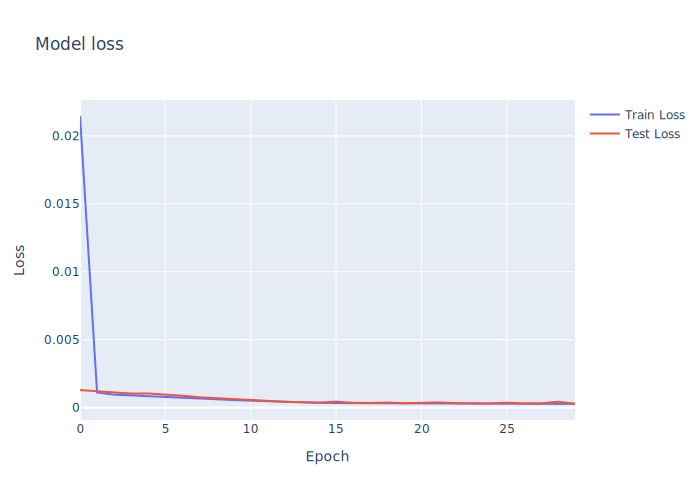

In [16]:
loss_fig = go.Figure()
loss_fig.add_trace(go.Scatter(y=history.history['loss'], mode='lines', name='Train Loss'))
loss_fig.add_trace(go.Scatter(y=history.history['val_loss'], mode='lines', name='Test Loss'))
loss_fig.update_layout(title='Model loss', xaxis_title='Epoch', yaxis_title='Loss')
loss_fig.show()

In [17]:
# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Invert predictions
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train_inv = scaler.inverse_transform([y_train])
y_test_inv = scaler.inverse_transform([y_test])


11/11 [==============================] - 0s 1ms/step


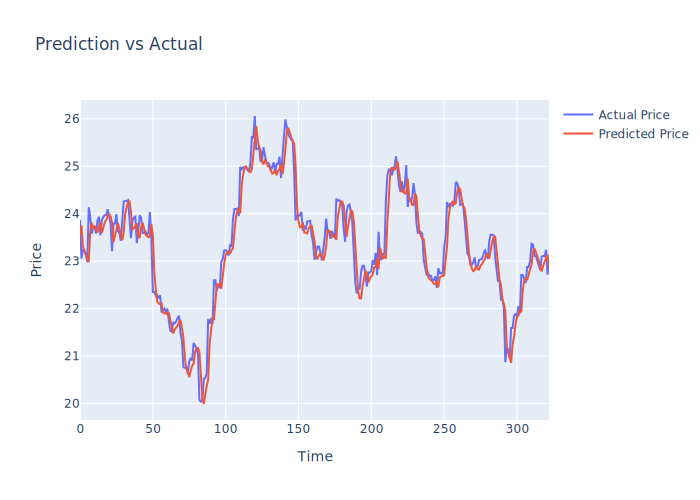

In [18]:
prediction_fig = go.Figure()
prediction_fig.add_trace(go.Scatter(y=y_test_inv[0], mode='lines', name='Actual Price'))
prediction_fig.add_trace(go.Scatter(y=test_predict[:,0], mode='lines', name='Predicted Price'))
prediction_fig.update_layout(title='Prediction vs Actual', xaxis_title='Time', yaxis_title='Price')
prediction_fig.show()

In [19]:
mse = mean_squared_error(y_test_inv[0], test_predict[:,0])
rmse = sqrt(mse)
print('MSE:', mse)
print('Test RMSE:', rmse)

MSE: 0.1171475967254769
Test RMSE: 0.3422683110156079


In [20]:
train_rmse = sqrt(mean_squared_error(y_train_inv[0], train_predict[:,0]))
print("Train RMSE:", train_rmse)

Train RMSE: 0.32003572966174554
